# Практическое задание

# Сивков Егор Сергеевич 192

### Задача Bike Sharing

Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной псотановке задачи доступно 9 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

### Анализ и визуализация данных

In [2]:
from sklearn import cross_validation, ensemble, grid_search, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [27]:
data = pd.read_csv('bike_sharing_train.csv')

In [26]:
print data[:24]

               datetime  season  holiday  workingday  weather   temp   atemp  \
0   2011-01-01 00:00:00       1        0           0        1   9.84  14.395   
1   2011-01-01 01:00:00       1        0           0        1   9.02  13.635   
2   2011-01-01 02:00:00       1        0           0        1   9.02  13.635   
3   2011-01-01 03:00:00       1        0           0        1   9.84  14.395   
4   2011-01-01 04:00:00       1        0           0        1   9.84  14.395   
5   2011-01-01 05:00:00       1        0           0        2   9.84  12.880   
6   2011-01-01 06:00:00       1        0           0        1   9.02  13.635   
7   2011-01-01 07:00:00       1        0           0        1   8.20  12.880   
8   2011-01-01 08:00:00       1        0           0        1   9.84  14.395   
9   2011-01-01 09:00:00       1        0           0        1  13.12  17.425   
10  2011-01-01 10:00:00       1        0           0        1  15.58  19.695   
11  2011-01-01 11:00:00       1        0

3 . Проанализируйте описание данных:

***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***count*** - number of total rentals

In [ ]:
datetime, workingday, weather, atemp

In [ ]:
humidity, windspeed

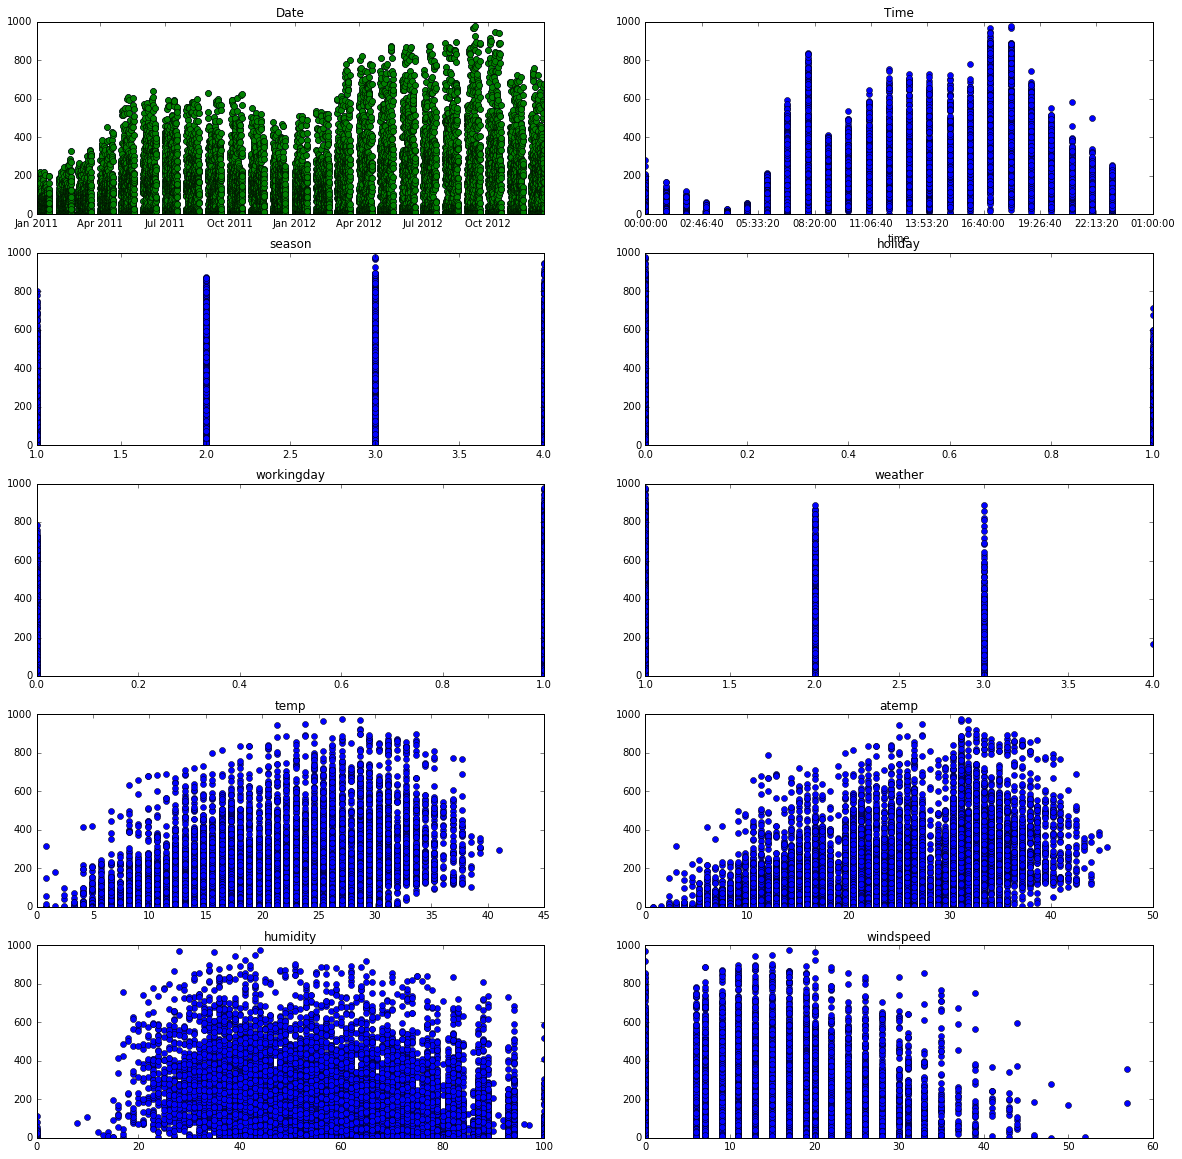

In [28]:
predictors = ["season", "holiday", "workingday", "weather", "temp", "atemp", "humidity",
                 "windspeed"]
from matplotlib import pyplot as plt
from datetime import datetime


f, ax = plt.subplots(5, 2, figsize = (20,20))

ax[0,0].plot_date([datetime.strptime(i, '%Y-%m-%d %H:%M:%S').date() for i in data["datetime"]], data["count"], 'o')
ax[0,0].set_title('Date')

Datet = [datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data["datetime"]]
Date = [i.date() for i in Datet]
Time = [i.time() for i in Datet]

ax[0,0].plot(Date, data["count"], 'o')
ax[0,0].set_title('Date')

ax[0,1].plot(Time, data["count"], 'o')
ax[0,1].set_title('Time')

for i in range(len(predictors)):
    ax[(i+2)/2,(i+2)%2].plot(data[predictors[i]],data["count"],'o')
    ax[(i+2)/2,(i+2)%2].set_title(predictors[i])
plt.show()

Видна зависимость количества арендованных велосипедов от месяца, в течение года, от времени суток. В 2012 году арендовали больше.Осенью арендуют больше всего. Среди прочих условий при которых прокат пользуется большим спросом: рабочий день, хорошая погода(1-го типа), температура около 25, температура по ощущениям около 30, низкая скорость ветра.

In [31]:
target = data['count']
data = data.drop('count',1)
date = data['datetime']

In [32]:
data_new = data.drop('datetime',1)
data_new = np.vstack([[int(((datetime.strptime(i, '%Y-%m-%d %H:%M:%S')-datetime(1970,1,1)).total_seconds()))
                           for i in date],np.matrix(data_new).T]).T
data_new = pd.DataFrame(data_new)
data_new.columns = data.columns[1:].insert(0, 'date')

data_new.corrwith(target)

date          0.310187
season        0.163439
holiday      -0.005393
workingday    0.011594
weather      -0.128655
temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
dtype: float64

In [33]:
data_new.corr()

,date,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
date,1.000000,0.480021,0.010988,-0.003658,-0.005048,0.180986,0.181823,0.032856,-0.086888
season,0.480021,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121
holiday,0.010988,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409
workingday,-0.003658,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373
weather,-0.005048,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261
temp,0.180986,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852
atemp,0.181823,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473
humidity,0.032856,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607
windspeed,-0.086888,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000


In [34]:
print 'mean'
print data_new.mean(0)
print 'std'
print data_new.std(0)

mean
date          1.324965e+09
season        2.506614e+00
holiday       2.856880e-02
workingday    6.808745e-01
weather       1.418427e+00
temp          2.023086e+01
atemp         2.365508e+01
humidity      6.188646e+01
windspeed     1.279940e+01
dtype: float64
std
date          18187689.411513
season               1.116174
holiday              0.166599
workingday           0.466159
weather              0.633839
temp                 7.791590
atemp                8.474601
humidity            19.245033
windspeed            8.164537
dtype: float64


### Линейные модели

In [35]:
fraction = 0.8
L = len(data_new)
count = int(fraction * L)
X_train = data_new[:count]
y_train = target[:count]

X_test = data_new[count:]
y_test = target[count:]

In [36]:
X_train_trans = preprocessing.StandardScaler().fit_transform(X_train)
X_test_trans = preprocessing.StandardScaler().fit_transform(X_test)

In [37]:
SGD = linear_model.SGDRegressor()
SGD.fit(X_train_trans,y_train)
lasso = linear_model.Lasso()
lasso.fit(X_train_trans, y_train)

print 'SGD'    
print 'train', metrics.mean_absolute_error(y_train, SGD.predict(X_train_trans))
print 'test ', metrics.mean_absolute_error(y_test, SGD.predict(X_test_trans))
print 'Lasso'
print 'train', metrics.mean_absolute_error(y_train, lasso.predict(X_train_trans))
print 'test', metrics.mean_absolute_error(y_test, lasso.predict(X_test_trans))

SGD
train 103.931990167
test  148.400595075
Lasso
train 103.632316595
test 149.719823168


In [39]:
print [i for i in data_new.columns]
print 'SGD coefficients' 
print SGD.coef_
print 'Lasso coefficients'
print lasso.coef_

['date', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
SGD coefficients: 
[ 35.7297841   -2.72280243  -1.11667656  -1.47595511  -2.87012376
  23.6425458   42.31820914 -49.68500182  10.15777041]
Lasso coefficients: 
[ 32.67707495  -0.          -0.64062528  -0.           0.           0.
  59.13749737 -46.66686173   7.29746812]


In [43]:
month = [datetime.strptime(i, '%Y-%m-%d %H:%M:%S').month for i in date]
time = [datetime.strptime(i, '%Y-%m-%d %H:%M:%S').hour for i in date]
water_in_air = [data_new['humidity'][i]*data_new['temp'][i] for i in range(len(data_new))]


data_upd = pd.DataFrame(np.vstack([month, time, water_in_air, np.matrix(data_new).T]).T)
data_upd.columns = data_new.columns.insert(0, 'water').insert(0, 'time').insert(0, 'month')

In [50]:
X_train = data_upd[:count]
X_test = data_upd[count:]

X_train_trans = preprocessing.StandardScaler().fit_transform(X_train)
X_test_trans = preprocessing.StandardScaler().fit_transform(X_test)

lasso.fit(X_train_trans,y_train)
print 'lasso'    
print 'train', metrics.mean_absolute_error(y_train, lasso.predict(X_train_trans))
print 'test ', metrics.mean_absolute_error(y_test, lasso.predict(X_test_trans))
print
print [i for i in data_upd.columns]
print 'lasso coefficients'
print lasso.coef_

SGD
train 94.8330738922
test  137.476111331

['month', 'time', 'water', 'date', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
SGD coefficients: 
[  0.          48.39995028 -52.01958989  35.22189452  -0.          -0.          -0.
  -3.69506068  29.03861038  62.23849653   0.           5.10928496]


In [52]:
# Пример:
# train_data, train_labels - DataFrame с обучающей выборкой и значения целевой функции на обучении
# test_data, test_labels - DataFrame с тестовой выборкой и значения целевой функции на тесте

# Создание индекса для бинарных признаков
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in X_train.columns], dtype = bool)

# Создание индекса для вещественных признаков
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'season', 'weather']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in X_train.columns], dtype = bool)

# Создание модели регресии
model = linear_model.SGDRegressor(random_state = 0)

# Объявление pipline -  цепочки преобразования данных, начиная от обработки данных в зависимости от их типа, и 
# заканчивая обучением модели. 

estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])),

        ])),
    ('model_fitting', model)
    ]
)

# С цепочкой можно работать как с одиночным преобразованием, в частности вызывать методы fit и predict 
estimator.fit(X_train, y_train)
metrics.mean_absolute_error(y_test, estimator.predict(X_test))

156.28894668388654

In [65]:
# Создание индекса для бинарных признаков
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in X_train.columns], dtype = bool)

# Создание индекса для вещественных признаков
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'water','date']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in X_train.columns], dtype = bool)

# Создание индекса для категориальных признаков
category_data_columns = ['hour', 'month', 'season', 'weather']
category_data_indices = np.array([(column in category_data_columns) for column in X_train.columns], dtype = bool)

# Создание модели регресии
model = linear_model.Lasso(random_state = 0)

# Объявление pipline -  цепочки преобразования данных, начиная от обработки данных в зависимости от их типа, и 
# заканчивая обучением модели. 

estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])),
            #categorical
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, category_data_indices])),
                ('encoding', preprocessing.OneHotEncoder())            
                        ])),

        ])),
    ('model_fitting', model)
    ]
)

# С цепочкой можно работать как с одиночным преобразованием, в частности вызывать методы fit и predict 
estimator.fit(X_train, y_train)
metrics.mean_absolute_error(y_test, estimator.predict(X_test))

148.09359128138786

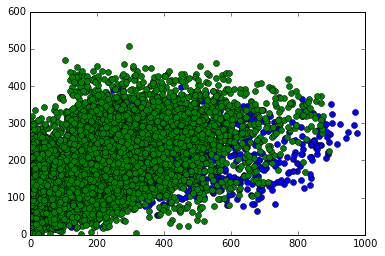

In [56]:
plt.plot(y_test, estimator.predict(X_test), 'o')
plt.plot(y_train, estimator.predict(X_train), 'o')
plt.show()

In [ ]:
Ну, вроде как и видно, что есть какая то зависимость, но огромный разброс все убивает...

### Случайный лес

In [58]:
RFR = ensemble.RandomForestRegressor()
RFR.fit(X_train, y_train)
print 'Train'
print metrics.mean_absolute_error(y_train, RFR.predict(X_train))
print 'Test'
print metrics.mean_absolute_error(y_test, RFR.predict(X_test))

Train
10.0299494718
Test
53.5982093664


In [63]:
for i in range(len(RFR.feature_importances_)):
    print X_train.columns[i], ': ', RFR.feature_importances_[i]

month :  0.00284851336338
time :  0.580682588996
water :  0.0112151520426
date :  0.202550840648
season :  0.00104659264658
holiday :  0.00353187466314
workingday :  0.0853255207524
weather :  0.0154662942878
temp :  0.0174498873488
atemp :  0.0460143264723
humidity :  0.0262536481339
windspeed :  0.00761476064569


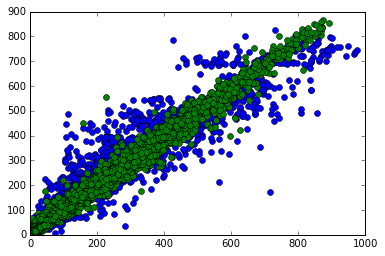

In [64]:
plt.plot(y_test, RFR.predict(X_test), 'o')
plt.plot(y_train, RFR.predict(X_train), 'o')
plt.show()

### Опциональная часть

Попробуйте улучшить результат, полученный на предыдущих шагах. В этом разделе можно и нужно пользоваться любыми изученными алгоритмами, инструментами и всем, чем вам захочется.

### Заключение

В этом разделе Вы можете написать, какие выводы Вы сделали в процессе работы над заданием, понравилось ли оно Вам, а также всё, что Вы о задании думаете =)